# CoinDector Deep Learning

In [ ]:
#Define your unique seed number
seed_number = 87

# Imports and Auxiliary Functions

In [ ]:
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, losses
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob, random, os
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
# Set the random seed for NumPy
np.random.seed(seed_number)

# Set the random seed for TensorFlow
tf.random.set_seed(seed_number)

# Set the random seed for Python's random module
random.seed(seed_number)

# Set the random seed for OpenCV (cv2)
cv2.setRNGSeed(seed_number)

In [ ]:
#Retrieving Dataset and Unet Weights
!rm -rf *coins*
!wget --no-check-certificate --no-cache --no-cookies https://www.ppgia.pucpr.br/~aghochuli/coins_and_masks.zip -O coins_and_masks.zip
!unzip -qo coins_and_masks.zip

!wget --no-check-certificate --no-cache --no-cookies https://www.ppgia.pucpr.br/~aghochuli/best_unet_model.h5 -O best_unet_model.h5

--2023-11-13 02:43:48--  https://www.ppgia.pucpr.br/~aghochuli/coins_and_masks.zip
Resolving www.ppgia.pucpr.br (www.ppgia.pucpr.br)... 104.18.11.132, 104.18.10.132, 2606:4700::6812:b84, ...
Connecting to www.ppgia.pucpr.br (www.ppgia.pucpr.br)|104.18.11.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69415532 (66M) [application/zip]
Saving to: ‘coins_and_masks.zip’

coins_and_masks.zip 100%[===================>]  66.20M  21.9MB/s    in 3.0s    

2023-11-13 02:43:52 (21.9 MB/s) - ‘coins_and_masks.zip’ saved [69415532/69415532]

--2023-11-13 02:43:54--  https://www.ppgia.pucpr.br/~aghochuli/best_unet_model.h5
Resolving www.ppgia.pucpr.br (www.ppgia.pucpr.br)... 104.18.11.132, 104.18.10.132, 2606:4700::6812:b84, ...
Connecting to www.ppgia.pucpr.br (www.ppgia.pucpr.br)|104.18.11.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63662136 (61M)
Saving to: ‘best_unet_model.h5’

best_unet_model.h5  100%[===================>]  60.71M  

In [ ]:
#Use this function to read image
def load_image_from_path(path,size=(224,224)):
    basename = os.path.basename(path)
    if ('mask' in basename):
        color = 0
    else:
        color = 1

    img = cv2.imread(path,color)
    img = cv2.resize(img,size)

    if color == 1:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    else:
        img = np.expand_dims(img,axis=2)
        img [img < 50] = 0
        img [img != 0] = 1

    return img

In [ ]:
#Conversts a probability mask to binary mask
def prob2mask(prob_masks,thresh=0.85):

  #Prob threshold
  prob_masks[ prob_masks < thresh ] = 0

  prob_masks = tf.math.argmax(prob_masks, axis=-1)

  pred_mask = prob_masks[..., tf.newaxis]

  return pred_mask


In [ ]:
#Funcao para mostrar a imagem e sua mascara
def display(display_list):
  plt.figure(figsize=(6, 3))

  title = ['Input Image', 'Mask', 'Predicted Mask']

  for i in range(len(display_list)):

    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    im = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(im)
    plt.axis('off')
  plt.show()

  return

In [ ]:
#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Data Preparation
Here, we load the train images and respective masks. Also, the test images are loaded.

In [ ]:
class_names = [5,10,25,50,100]
train_imgs = []
train_masks = []
train_labels = []

IMG_SIZE=(224,224)

filelist = glob.glob('coins_and_masks/train/' + '*mask.jpg')
random.shuffle(filelist)

for mask_path in filelist:

    #Converts mask_path to input path (supress 'mask')
    input_path = mask_path[:-9] + '.jpg'

    img = load_image_from_path(input_path,IMG_SIZE)
    train_imgs.append(img)

    msk = load_image_from_path(mask_path,IMG_SIZE)
    train_masks.append(msk)

    cls = int(os.path.basename(mask_path).split('_')[0])
    train_labels.append(cls)

train_imgs = np.array(train_imgs)
train_masks = np.array(train_masks)
train_labels = np.searchsorted(class_names, train_labels)

#Test Images
test_imgs = []
test_labels = []

for path in glob.glob('coins_and_masks/test/' + '*.jpg*'):
    img = load_image_from_path(path,IMG_SIZE)
    test_imgs.append(img)
    cls = int(os.path.basename(path).split('_')[0])
    test_labels.append(cls)

test_imgs = np.array(test_imgs)
test_labels = np.searchsorted(class_names, test_labels)


Label: 4


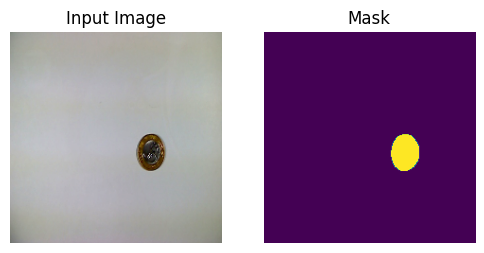

Label: 0


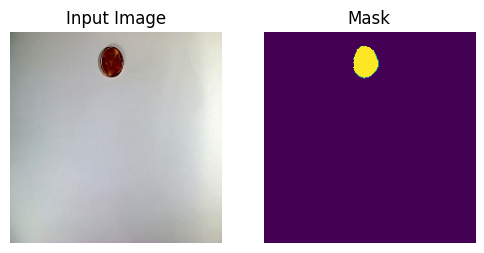

Label: 4


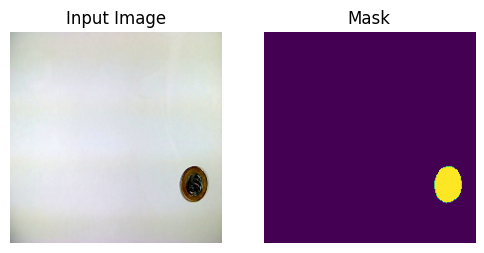

In [ ]:
n_images = 3
for img,msk,lbl in zip(train_imgs[:n_images],train_masks[:n_images],train_labels[:n_images]):
    print(f"Label: {lbl}")
    display([img,msk])

#Section 1 - Unet Model

The trained Unet model is provided. So, the use is direct.
To exemplify, let us try a few test images and plot the result.

1/1 [==============================] - 9s 9s/step


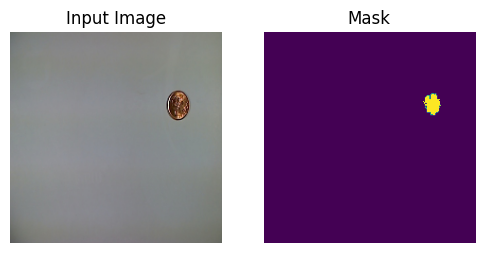

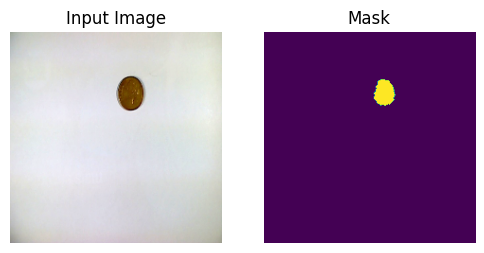

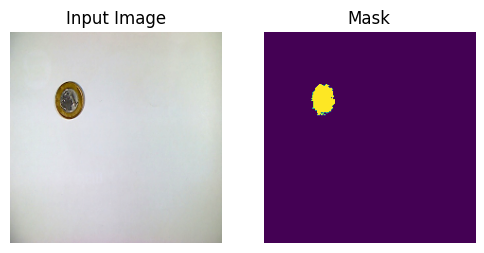

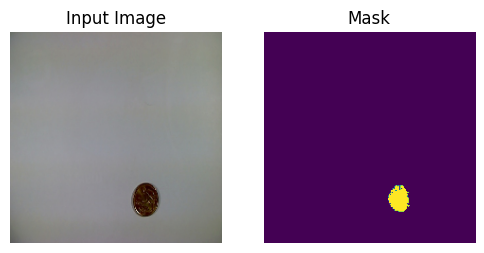

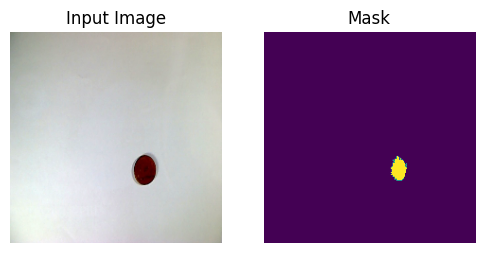

In [ ]:
unet = load_model('best_unet_model.h5')

#Lets predict 5 images
prob_masks = unet.predict(test_imgs[:5])

#convert probabilities into a binary mask
pred_masks = prob2mask(prob_masks)

for img, msk in zip(test_imgs[:5],pred_masks[:5]):
  display([img,msk])

As observed, the unet was loaded and it is able to provide a mask from an image containing a single coin

# Section 2 - CNN Training

Here you should train a Convolutional Neural Network to recognize a single coins (cropped). To that you should flow the following steps:

* Crop all **train images** using their respective masks

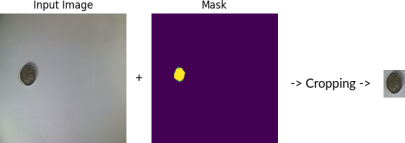

* Whether you judge it necessary, apply a data augmentation technique to enhance the representations.

* Train a CNN with the cropped dataset
  * You should train two models: a) You own architecture from Scracth, and b) A transfer-learning from MobileNetV2

**IMPORTANT NOTE: Here you should use only the training samples. None of the test samples should be used for training**

In [ ]:
def create_ellipse_matrix(size, a, b):
    # Initialize an empty matrix filled with zeros
    matrix = np.zeros((size, size), dtype=int)

    # Calculate the center of the matrix
    center = (size - 1) / 2

    # Iterate through each element in the matrix
    for i in range(size):
        for j in range(size):
            # Calculate the distance from the current element to the center
            distance = ((i - center) / a) ** 2 + ((j - center) / b) ** 2

            # If the distance satisfies the ellipse equation, set the element to 1
            if distance <= 1:
                matrix[i, j] = 1

    return matrix

In [ ]:
# Certifique-se de que train_imgs e train_masks tenham o mesmo número de amostras
num_samples = len(train_imgs)

# Crie listas vazias para armazenar as imagens cortadas e suas máscaras correspondentes
cropped_coins = []
cropped_coins_label = []

for i in range(num_samples):

    img =train_imgs[i]
    kernel = np.array(create_ellipse_matrix(17,1,1), dtype=np.uint8)
    im_erode = cv2.dilate(train_masks[i],kernel)
    im_open = cv2.erode(im_erode,kernel)

    mask = im_open

    connectivity = 8  # You need to choose 4 or 8 for connectivity type
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(mask , connectivity , cv2.CV_32S)
    for k in range(1,num_labels):
        #temp = img.copy()

        x,y,w,h = stats[k][:4]

        # area = stats[i][4]
        # cx,cy = centroids[i]
        component = img[y:y+h, x:x+w]
        cropped_coins.append(cv2.resize(component,(96,96)))
        cropped_coins_label.append(train_labels[i])

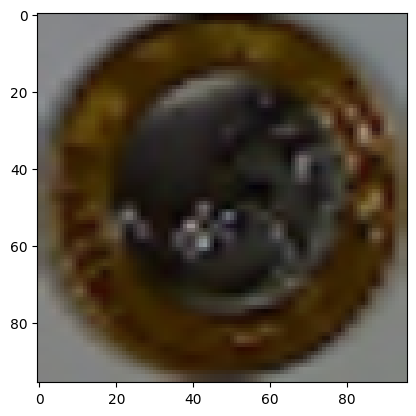

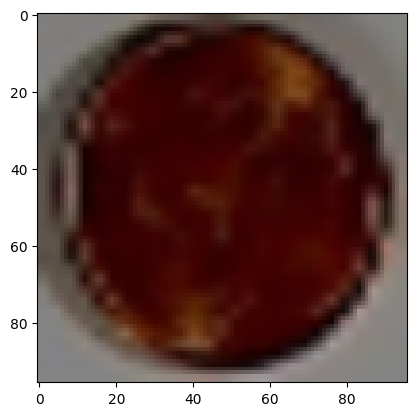

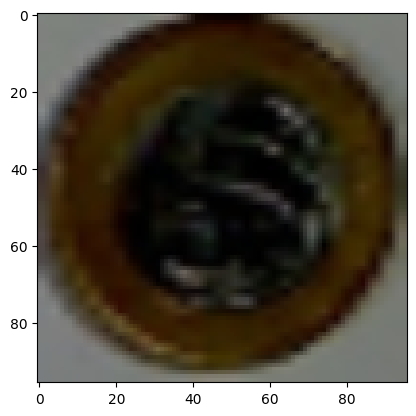

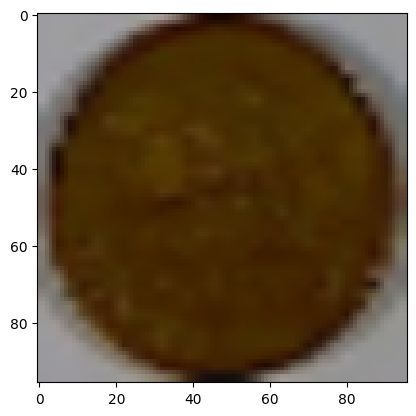

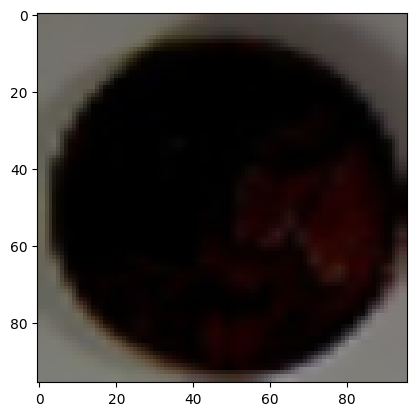

In [ ]:
for img, lbl in zip(cropped_coins[:5],cropped_coins_label[:5]):
  plt.imshow(img)
  plt.show()

In [ ]:
data_train, data_test, labels_train, labels_test = train_test_split(cropped_coins, cropped_coins_label, stratify=cropped_coins_label, test_size=0.15, random_state=seed_number)

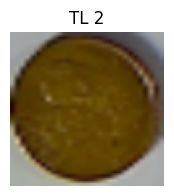

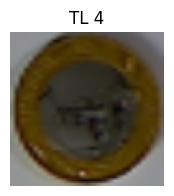

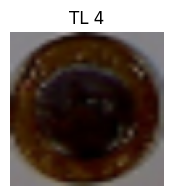

In [ ]:
for i in range(5,8):
    plt.figure(figsize=(2, 2))
    plt.imshow(data_train[i])
    plt.title(f'TL {labels_train[i]}')
    plt.axis('off')
    plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(96,
                                  96,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
conv_layers =  tf.keras.applications.mobilenet_v2.MobileNetV2(None, include_top=False, input_tensor=tf.keras.layers.Input((96,96,3)),classes=5)
conv_layers.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
modelCNN = tf.keras.Sequential([
  data_augmentation, #Data Augmentation
  layers.Rescaling(1./255, input_shape=(96, 96, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.3), #Regularization
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
])

In [ ]:
epochs_ = 30
modelCNN.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
historyCNN = modelCNN.fit(np.array(data_train), np.array(labels_train), epochs=epochs_, validation_data=(np.array(data_test), np.array(labels_test)))

Epoch 1/30
44/44 [==============================] - 6s 27ms/step - loss: 1.1792 - acc: 0.5079 - val_loss: 0.8532 - val_acc: 0.6612
Epoch 2/30
44/44 [==============================] - 1s 16ms/step - loss: 0.8443 - acc: 0.6655 - val_loss: 0.6657 - val_acc: 0.7061
Epoch 3/30
44/44 [==============================] - 1s 16ms/step - loss: 0.7389 - acc: 0.7088 - val_loss: 0.6193 - val_acc: 0.7429
Epoch 4/30
44/44 [==============================] - 1s 15ms/step - loss: 0.6626 - acc: 0.7211 - val_loss: 0.5776 - val_acc: 0.7551
Epoch 5/30
44/44 [==============================] - 1s 15ms/step - loss: 0.6181 - acc: 0.7536 - val_loss: 0.5698 - val_acc: 0.7796
Epoch 6/30
44/44 [==============================] - 1s 16ms/step - loss: 0.5897 - acc: 0.7652 - val_loss: 0.5642 - val_acc: 0.7673
Epoch 7/30
44/44 [==============================] - 1s 15ms/step - loss: 0.5639 - acc: 0.7710 - val_loss: 0.5497 - val_acc: 0.7347
Epoch 8/30
44/44 [==============================] - 1s 15ms/step - loss: 0.5803 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


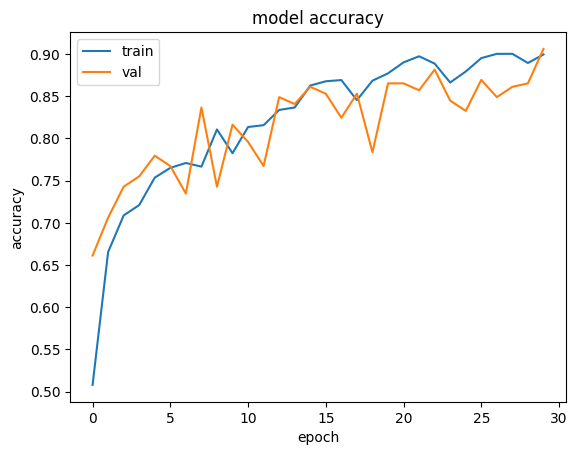

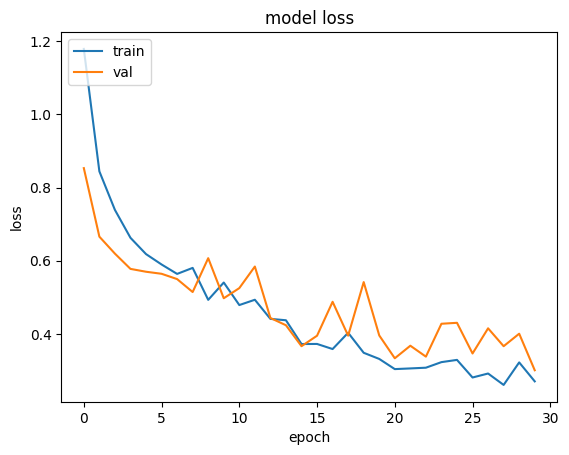

In [ ]:
plot_history(historyCNN)

In [ ]:
MobileNet = tf.keras.Sequential([
    data_augmentation,
    conv_layers,
    layers.Dropout(0.3), #Regularization
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])
MobileNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 3, 3, 1280)        2257984   
 tional)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1474688   
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                      

In [ ]:
epochs_ = 30
MobileNet.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
historyMN = MobileNet.fit(np.array(data_train), np.array(labels_train), epochs=epochs_, validation_data=(np.array(data_test), np.array(labels_test)))

Epoch 1/30
44/44 [==============================] - 6s 56ms/step - loss: 4.7396 - acc: 0.3866 - val_loss: 1.1508 - val_acc: 0.5592
Epoch 2/30
44/44 [==============================] - 1s 18ms/step - loss: 1.2132 - acc: 0.5354 - val_loss: 1.0741 - val_acc: 0.5714
Epoch 3/30
44/44 [==============================] - 1s 16ms/step - loss: 1.1017 - acc: 0.5867 - val_loss: 1.4183 - val_acc: 0.4898
Epoch 4/30
44/44 [==============================] - 1s 17ms/step - loss: 1.1211 - acc: 0.5643 - val_loss: 0.9612 - val_acc: 0.5918
Epoch 5/30
44/44 [==============================] - 1s 22ms/step - loss: 1.0579 - acc: 0.5918 - val_loss: 0.8643 - val_acc: 0.6449
Epoch 6/30
44/44 [==============================] - 1s 22ms/step - loss: 0.9777 - acc: 0.6243 - val_loss: 0.9951 - val_acc: 0.6041
Epoch 7/30
44/44 [==============================] - 1s 21ms/step - loss: 0.9881 - acc: 0.6322 - val_loss: 1.0585 - val_acc: 0.6286
Epoch 8/30
44/44 [==============================] - 1s 22ms/step - loss: 0.8360 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


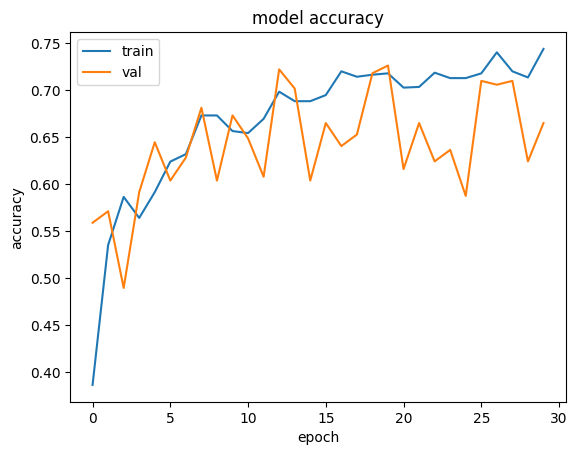

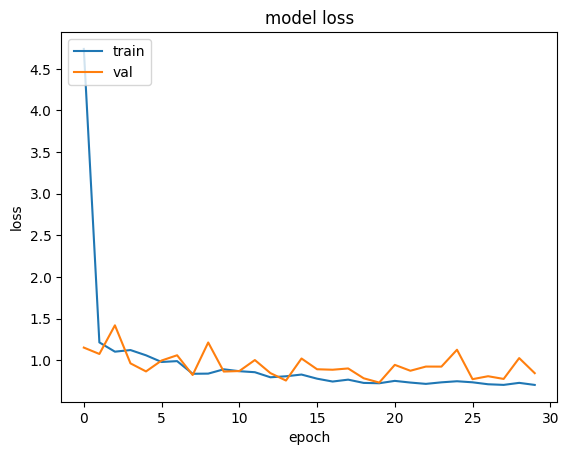

In [ ]:
plot_history(historyMN)

# Section 3: The segmentation/recognition pipeline (ALL TOGETHER)

Now implement the inference pipeline. A test sample should be present first to the UNET. Then, from the predicted mask, crop the bbox and classify it with the trained CNN.

Therefore, you should provide the classification report, confusion matrix and plot some predictions.



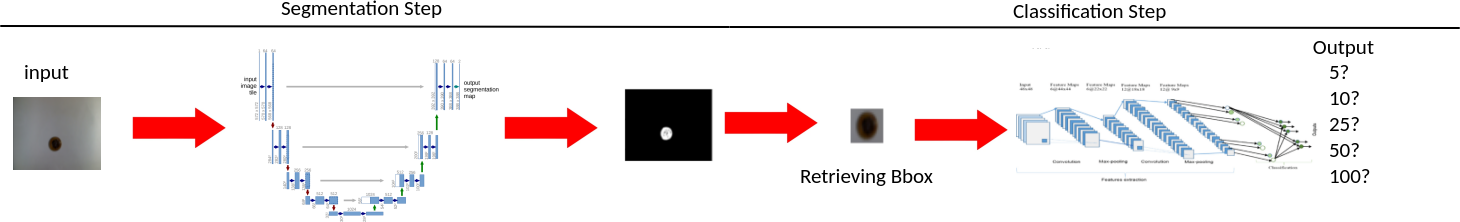

In [ ]:
def performance_evaluation(y_test, predictions,info_message,figsize=(18, 4)):

  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predictions)}\n")
  print(class_names)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()

20/20 [==============================] - 0s 15ms/step
Evaluation of  Lenet
              precision    recall  f1-score   support

           0       0.70      0.79      0.75       107
           1       0.70      0.65      0.68       113
           2       0.71      0.65      0.67       130
           3       0.78      0.77      0.77       169
           4       0.86      0.90      0.88       115

    accuracy                           0.75       634
   macro avg       0.75      0.75      0.75       634
weighted avg       0.75      0.75      0.75       634


[5, 10, 25, 50, 100]


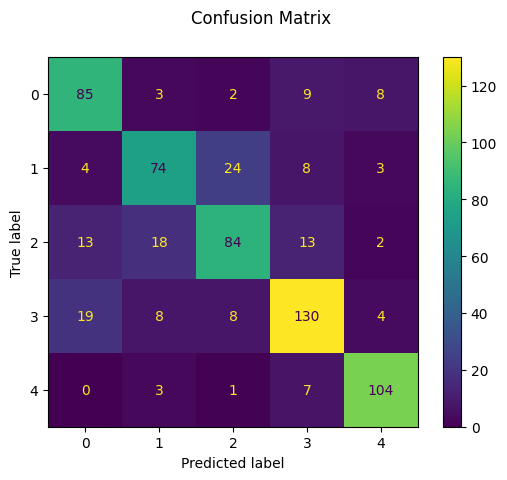

In [ ]:
#The Code goes
masks = prob2mask(unet.predict(np.array(test_imgs)),thresh=0.2)
#np.array(data_test), np.array(labels_test)
# Crie listas vazias para armazenar as imagens cortadas e suas máscaras correspondentes
test_coins = []
test_label = []

for img, mask, label in zip(np.array(test_imgs), masks, np.array(test_labels)):

    kernel = np.array(create_ellipse_matrix(17,1,1), dtype=np.uint8)
    im_erode = cv2.dilate(mask.numpy().astype('uint8'),kernel)
    im_open = cv2.erode(im_erode,kernel)

    open_mask = im_open

    connectivity = 8  # You need to choose 4 or 8 for connectivity type
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(open_mask , connectivity , cv2.CV_32S)
    for i in range(1, num_labels):
        x,y,w,h = stats[i][:4]
        component = img[y:y+h, x:x+w]
        test_coins.append(cv2.resize(component,(96,96)))
        test_label.append(label)

predictions = modelCNN.predict(np.array(test_coins))

predictions = np.argmax(predictions, axis=1)
performance_evaluation(np.array(test_label),predictions,'Lenet')


20/20 [==============================] - 1s 35ms/step
Evaluation of  Lenet
              precision    recall  f1-score   support

           0       0.67      0.39      0.49       107
           1       0.57      0.72      0.64       113
           2       0.66      0.59      0.63       130
           3       0.70      0.83      0.76       169
           4       0.85      0.84      0.85       115

    accuracy                           0.69       634
   macro avg       0.69      0.67      0.67       634
weighted avg       0.69      0.69      0.68       634


[5, 10, 25, 50, 100]


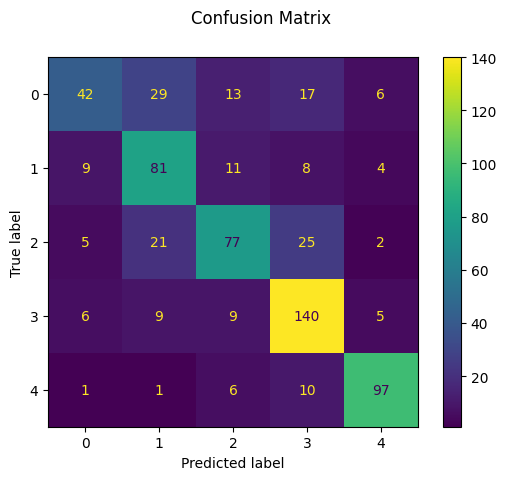

In [ ]:
#The Code goes
masks = prob2mask(unet.predict(np.array(test_imgs)),thresh=0.2)
#np.array(data_test), np.array(labels_test)
# Crie listas vazias para armazenar as imagens cortadas e suas máscaras correspondentes
test_coins = []
test_label = []

for img, mask, label in zip(np.array(test_imgs), masks, np.array(test_labels)):

    kernel = np.array(create_ellipse_matrix(17,1,1), dtype=np.uint8)
    im_erode = cv2.dilate(mask.numpy().astype('uint8'),kernel)
    im_open = cv2.erode(im_erode,kernel)

    open_mask = im_open

    connectivity = 8  # You need to choose 4 or 8 for connectivity type
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(open_mask , connectivity , cv2.CV_32S)
    for i in range(1, num_labels):
        x,y,w,h = stats[i][:4]
        component = img[y:y+h, x:x+w]
        test_coins.append(cv2.resize(component,(96,96)))
        test_label.append(label)

predictions = MobileNet.predict(np.array(test_coins))

predictions = np.argmax(predictions, axis=1)
performance_evaluation(np.array(test_label),predictions,'Lenet')

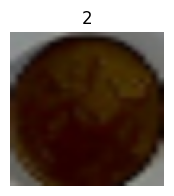

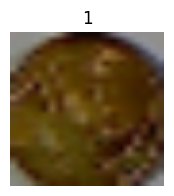

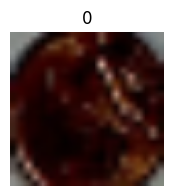

In [ ]:
for i in range(5,8):
    plt.figure(figsize=(2, 2))
    plt.imshow(test_coins[i])
    plt.title(f'{test_label[i]}')
    plt.axis('off')
    plt.show()

#Final Discussion:

a) Provide an in-depth discussion of the results supported by plotting some missed and correct recognition. Which architecture performed better ? Is there a remaining bottleneck?

## Summary

Analyzing our results, we were able to achieve 75% with our custom CNN and 69% with the MobileNetV2.
Our approach consisted of:
- Generating masks using UNET
- Applying kernel operations
- Finding components within the mask and finding an accurate bounding box
- Crop the original image
- Feed the image to the Model for training

Note: for training we used the mask supplied with the dataset, the UNET was used for the inference pipeline

## Method (in-depth)

1. Generating mask using UNET
    
    At this stage we use the supplied UNET model and functions to convert the probabilities into a mask, though we had to change the default threshold value 0.85 to 0.20. This change was made after we noticed the bounding box generated by these masks were a bit smaller than the coin.

2. Applying Kernel Operations

    Not unlike our first implementation with shallow learning, we used kernel operations in order to improve the masks. Our first operation was a dilate operation using an eliptical kernel in order to fill the inside of the coin. Our second operation was an erode operation, in order to preserve the coin rounded shape and remove the extra border pixels added by the dilation.

3. Finding Components within the mask

    Same as with out shallow learning, we used OpenCV conected components to search and find where the coin mask was located. With it we were able to extract the bounding box.

4. Crop the original image

    We used the component bounding box to crop the image and rescale it to 96x96 pixels. We attempted 128x128 pixels in early stages of development, but using such large images did not improve the models significantly, insted it only increased the size of the model into about 120MB (instead of 24MB). We've decided to use the "lighter" model, which would in a real world environment spend less computational power and thus be cheaper.

5. Feed the image to the Model for training

    On this stage we fed the cropped images into the model for training. Since we were supposed to only train images using the training dataset, we split it 85:15 for training and validation. At first we had accuracies up to 100%, which meant the model was clearly overfitting. Our solution was to add Data Augmentation to add more variety into training, and to add Dropout. We tested with different values for dropout and found out 0.3 gave the best result. Plotting the history helped us visualize that the overfitting was gone, but we later found out that the model was still underperforming when predicting validation images.

## Validation Results

Our custom CNN was able to achieve 75% accuracy, with 89% being reported in training. We believe this difference is due to two main factors: small sample of images being used for training and validating (fit stage) and difference between the training masks and our masks in the inference pipeline (we found out the default value in the prob2masks function yielded less than optimal masks).

With the MobileNet we achieved 69% accuracy, with 71% being reported in training, a much closer result than our own CNN. Once again, we believe that a small number of test samples and differences in masking were key to a difference in accuracy between training and validation. we believe this is also the main factor preventing the model from achieving higher accuracies.

We've identified that one current bottleneck is the size of the training images. With only about 1600 example images there's only so much a model can learn (without overfitting). Another solution for this would be to add Data Augmentation in another step before the model, for instance apply transformations to images before they are masked and cropped


b) Discuss the deep learning approach making a parallel with the shallow approach made in the PJBL1.

After getting positive results with this approach, we came to the conclusion deep learning can be very helpful in scenarios where the features for classification arent apparent or simple/easy to extract. For instance in our shallow learning we tried using the coin size and color for classification and we achieved accurancy of 20%. Considering this is a multiclass problem with 5 classes, considering a model that would assing a class at random, it accuracy would be around 20% (100%/5). In other words, using shallow learning did not get any results better than just pure guessing. With this, we can conclude that for this problem in which texure, color and other parameters are important, deep learning models were very efficient in detecting features and classifing them insted of relying on humans to search and extract these features

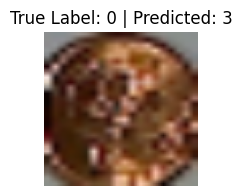

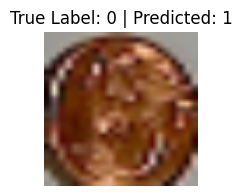

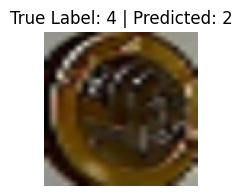

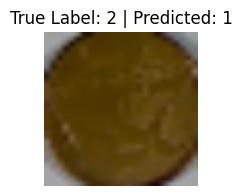

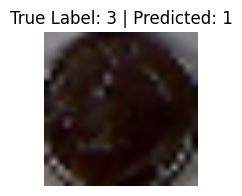

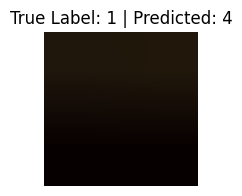

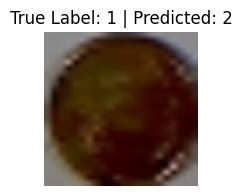

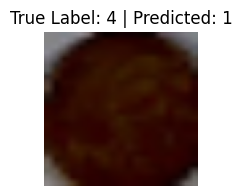

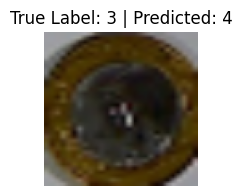

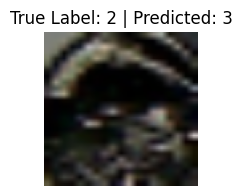

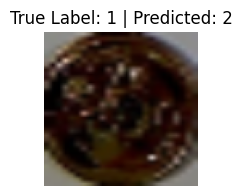

In [ ]:
pimg = 0
for i, (img,pred, label) in enumerate(zip(test_coins, predictions, test_labels)):
    if pred != label:
        plt.figure(figsize=(2, 2))
        plt.title(f"True Label: {label} | Predicted: {pred}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        pimg += 1
        if pimg > 10:
            break